# ECE 381V - Statistical Machine Learning
# Project - Community Segmentation
# Student Name: Babuji Periasubbramaniam
# Student ID: bp26282


The objective of this project is to perform **RFM analysis** and apply unsupervised learning techniques, specifically **k-Means++ clustering**, to distinguish different groups within a community. The project aims to identify meaningful clusters based on socio-economic indicators without prior labels in the dataset. By leveraging dimensionality reduction and advanced visualization methods, the goal is to provide insights into community structures and characteristics.



# Project Goal

In this project, will use transnational data set from an online retail store which contains all the transactions occurring between certain dates. Will segement the customers based on RFM (R (Recency): Number of days since last purchase, F (Frequency): Number of tracsactions and M (Monetary): Total amount of transactions (revenue contributed)) so that the company can target its customers efficiently. Apply the K-means algorithm to the normalized RFM data. Will analyze the clusters obtained from K-means to understand the characteristics of each segment and then develop targeted marketing strategies or campaigns tailored to the needs and behaviors of each customer segment identified.

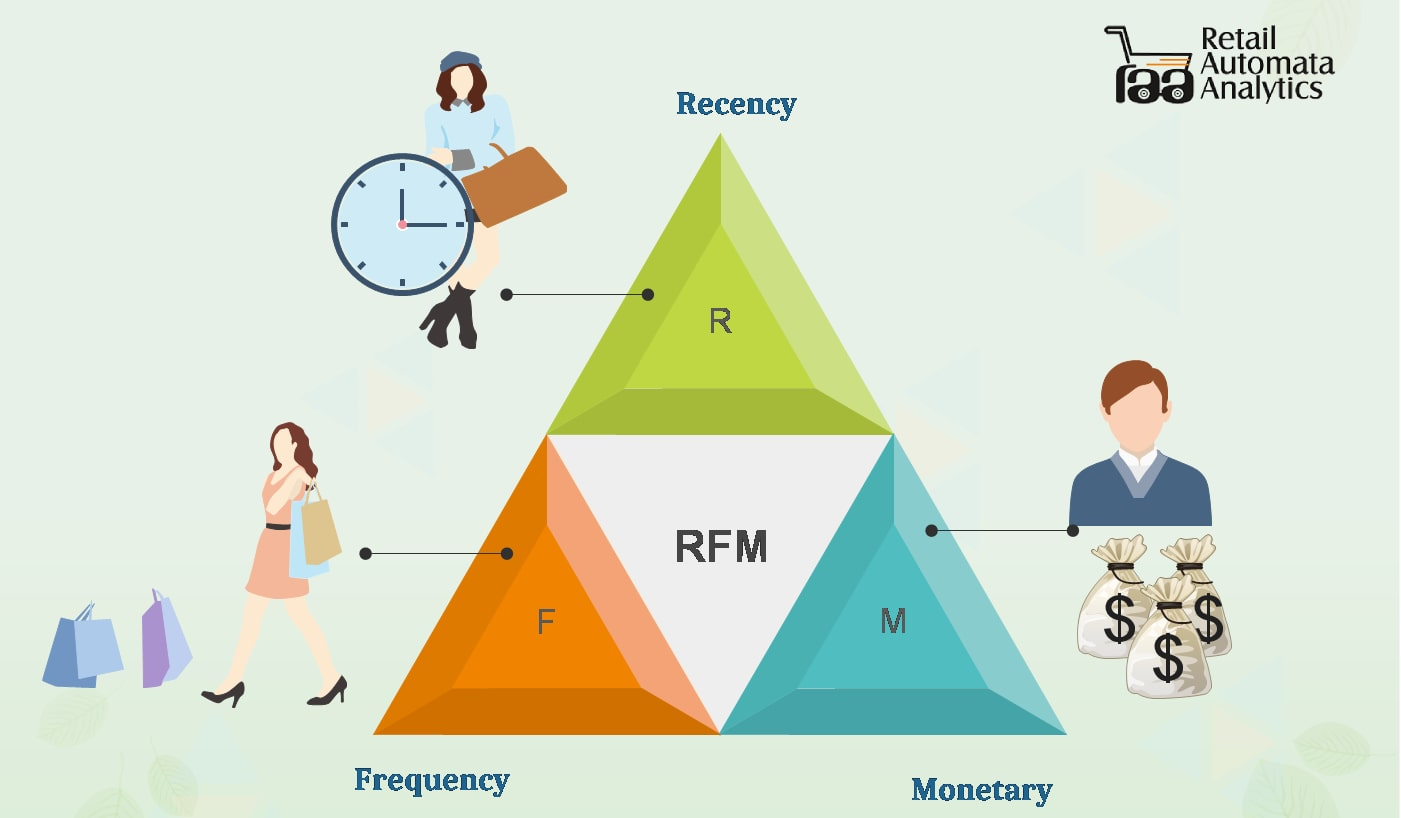

Our goal is to cluster the customers in the given dataset to:

1) Identifiy valuable customers

2) Increase revenue and customer retention

3) Understand customer trends and behaviors

RFM (Recency, Frequency, Monetary) analysis is a marketing technique used to segment customers based on their transaction history. It involves analyzing three key metrics:

1. Recency: How recently a customer made a purchase.
2. Frequency: How often a customer makes a purchase.
3. Monetary: How much money a customer spends.

K-means clustering is a popular unsupervised machine learning algorithm used for clustering data points into groups based on similarity. It works by iteratively assigning data points to clusters and updating the cluster centroids until convergence.

Combining RFM analysis with K-means clustering can help businesses identify different customer segments based on their purchasing behavior.

Here's how you can apply K-means clustering to RFM data:

1. **RFM Calculation**: Calculate the RFM values for each customer based on their transaction history.

2. **Normalization**: Normalize the RFM values to ensure that all three metrics are on the same scale.

3. **K-means Clustering**: Apply the K-means algorithm to the normalized RFM data. Choose the number of clusters (K) based on business objectives or using techniques like the elbow method or silhouette score.

4. **Interpretation**: Analyze the clusters obtained from K-means to understand the characteristics of each segment. Assign meaningful labels to each cluster based on their RFM values.

5. **Actionable Insights**: Develop targeted marketing strategies or campaigns tailored to the needs and behaviors of each customer segment identified.

By combining RFM analysis with K-means clustering, businesses can gain valuable insights into their customer base and tailor their marketing efforts to maximize customer satisfaction and revenue.


In [1]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt



# Dataset

In [2]:
# Import Data Set
import warnings
warnings.filterwarnings(action="ignore")
from google.colab import files
uploaded = files.upload()
retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)

Saving OnlineRetail.csv to OnlineRetail.csv


In [3]:
retail.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [4]:
# Shape of data frame

retail.shape

(541909, 8)

In [5]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Data Preprocessing

In [6]:
# Calculating the Missing Values % contribution in the data frame

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [7]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(406829, 8)

In [8]:
# Changing the datatype of Customer Id

retail['CustomerID'] = retail['CustomerID'].astype(str)

In [9]:
# Add new attribute : Monetary

retail['Monetary'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Monetary'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

CustomerID  Monetary
0    12346.0      0.00
1    12347.0   4310.00
2    12348.0   1797.24
3    12349.0   1757.55
4    12350.0    334.40

In [10]:
# Add new attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

CustomerID  Frequency
0    12346.0          2
1    12347.0        182
2    12348.0         31
3    12349.0         73
4    12350.0         17

In [11]:
# Merging the two data frames - Monetary and Frequency

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

CustomerID  Monetary  Frequency
0    12346.0      0.00          2
1    12347.0   4310.00        182
2    12348.0   1797.24         31
3    12349.0   1757.55         73
4    12350.0    334.40         17

In [12]:
# Add new attribute : Recency

# Convert to datetime to proper datatype with the format - '%m/%d/%Y %H:%M'

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format='%m/%d/%Y %H:%M')


In [13]:
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [14]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  Monetary  \
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom     15.30   
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom     20.34   
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom     22.00   
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom     20.34   
4 2010-12-01 08:26:00       3.39    17850.0  United Kingdom     20.34   

               Diff  
0 373 days 04:24:00  
1 373 days 04:24:00  
2 373 days 04:24:00  
3 373 days 04:24:00  
4 373 days 04:24:00

In [15]:
# Compute recency of customer

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

CustomerID              Diff
0    12346.0 325 days 02:33:00
1    12347.0   1 days 20:58:00
2    12348.0  74 days 23:37:00
3    12349.0  18 days 02:59:00
4    12350.0 309 days 20:49:00

In [16]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

CustomerID  Diff
0    12346.0   325
1    12347.0     1
2    12348.0    74
3    12349.0    18
4    12350.0   309

In [17]:
# Merge the dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Monetary', 'Frequency', 'Recency']
rfm.head()

CustomerID  Monetary  Frequency  Recency
0    12346.0      0.00          2      325
1    12347.0   4310.00        182        1
2    12348.0   1797.24         31       74
3    12349.0   1757.55         73       18
4    12350.0    334.40         17      309

#  Plot RFM distributions

In [18]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4372 non-null   object 
 1   Monetary    4372 non-null   float64
 2   Frequency   4372 non-null   int64  
 3   Recency     4372 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 136.8+ KB


In [19]:
rfm.describe()


Monetary    Frequency      Recency
count    4372.000000  4372.000000  4372.000000
mean     1898.459701    93.053294    91.047118
std      8219.345141   232.471608   100.765435
min     -4287.630000     1.000000     0.000000
25%       293.362500    17.000000    16.000000
50%       648.075000    42.000000    49.000000
75%      1611.725000   102.000000   142.000000
max    279489.020000  7983.000000   373.000000

In [20]:
# Calculate Recency, Frequency and Monetary scores of each customer

def recency_scoring(rfm):
    if rfm.Recency <= 17.0:
        recency_score = 4
    elif rfm.Recency <= 50.0:
        recency_score = 3
    elif rfm.Recency <= 143.0:
        recency_score = 2
    else:
        recency_score = 1
    return recency_score

rfm['Recency_Score'] = rfm.apply(recency_scoring, axis=1)
rfm.sample(10)

def frequency_scoring(rfm):
    if rfm.Frequency >= 103.0:
        frequency_score = 4
    elif rfm.Frequency >= 43.0:
        frequency_score = 3
    elif rfm.Frequency >= 18.0:
        frequency_score = 2
    else:
        frequency_score = 1
    return frequency_score

rfm['Frequency_Score'] = rfm.apply(frequency_scoring, axis=1)
rfm.sample(10)

def monetary_scoring(rfm):
    if rfm.Monetary >= 1611.73:
        monetary_score = 4
    elif rfm.Monetary >= 648.08:
        monetary_score = 3
    elif rfm.Monetary >= 293.37:
        monetary_score = 2
    else:
        monetary_score = 1
    return monetary_score

rfm['Monetary_Score'] = rfm.apply(monetary_scoring, axis=1)
rfm.sample(10)


CustomerID   Monetary  Frequency  Recency  Recency_Score  \
3539    17142.0     579.00         15      238              1   
1656    14581.0     138.60         17       16              4   
3000    16403.0     161.05         15      301              1   
4177    18019.0      38.45          5       51              2   
2894    16255.0    2609.30        274       16              4   
1821    14806.0     193.39         11       74              2   
4233    18102.0  256438.49        433        0              4   
1110    13835.0     834.57         55       24              3   
3042    16457.0     208.36          9      217              1   
3258    16756.0     239.40         13      214              1   

      Frequency_Score  Monetary_Score  
3539                1               2  
1656                1               1  
3000                1               1  
4177                1               1  
2894                4               4  
1821                1               1  
4233                4               4  
1110                3               3  
3042                1               1  
3258                1               1

In [21]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       4372 non-null   object 
 1   Monetary         4372 non-null   float64
 2   Frequency        4372 non-null   int64  
 3   Recency          4372 non-null   int64  
 4   Recency_Score    4372 non-null   int64  
 5   Frequency_Score  4372 non-null   int64  
 6   Monetary_Score   4372 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 239.2+ KB


In [22]:
# Calculate RFM score of each customer

def rfm_scoring(customer):
    return str(int(customer['Recency_Score'])) + str(int(customer['Frequency_Score'])) + str(int(customer['Monetary_Score']))


rfm['Customer_RFM_Score'] = rfm.apply(rfm_scoring, axis=1)
rfm.sample(8)

CustomerID  Monetary  Frequency  Recency  Recency_Score  Frequency_Score  \
3519    17111.0    248.61         30       46              3                2   
3909    17655.0   2571.74         93       10              4                3   
3853    17580.0    215.72         45      252              1                3   
3473    17048.0    864.32         48      114              2                3   
2361    15537.0    110.92         24      162              1                2   
3948    17704.0    885.19         31      168              1                2   
3651    17309.0     82.75         12       94              2                1   
3447    17014.0    565.58         75        7              4                3   

      Monetary_Score Customer_RFM_Score  
3519               1                321  
3909               4                434  
3853               1                131  
3473               3                233  
2361               1                121  
3948               3                123  
3651               1                211  
3447               2                432

In [23]:
!pip install plotly
import plotly.express as px
fig = px.histogram(rfm, x = rfm['Customer_RFM_Score'].value_counts().index,
                   y = rfm['Customer_RFM_Score'].value_counts().values,
                   title = 'Customer RFM Score Distribution',
                   labels = dict(x = "Customer_RFM_Score", y ="counts"))
fig.show()

In [24]:
rfm['RFM_Label'] = rfm['Recency_Score'] + rfm['Frequency_Score'] + rfm['Monetary_Score']

rfm.sample(8)

CustomerID  Monetary  Frequency  Recency  Recency_Score  Frequency_Score  \
4039    17837.0   1560.53        172       41              3                4   
3293    16800.0   1201.49        164       10              4                4   
1372    14196.0    335.52          6      106              2                1   
2054    15128.0   1419.54        111       59              2                4   
1628    14541.0   1461.65        111       58              2                4   
3717    17397.0    696.41         92       21              3                3   
70      12432.0   5059.32        108       42              3                4   
24      12374.0    742.93         33       24              3                2   

      Monetary_Score Customer_RFM_Score  RFM_Label  
4039               3                343         10  
3293               3                443         11  
1372               2                212          5  
2054               3                243          9  
1628               3                243          9  
3717               3                333          9  
70                 4                344         11  
24                 3                323          8

In [25]:
rfm.groupby(['Customer_RFM_Score']).size().sort_values(ascending=False)[:]

Customer_RFM_Score
444    481
111    389
122    209
344    203
211    181
      ... 
124      6
414      4
142      4
241      1
441      1
Length: 62, dtype: int64

In [26]:
rfm[rfm['Customer_RFM_Score']=='443'].head(3)

CustomerID  Monetary  Frequency  Recency  Recency_Score  Frequency_Score  \
421    12877.0   1535.77        154        3              4                4   
462    12937.0   1504.27        120       14              4                4   
515    13012.0   1311.62        107        8              4                4   

     Monetary_Score Customer_RFM_Score  RFM_Label  
421               3                443         11  
462               3                443         11  
515               3                443         11

In [27]:
np.sort(rfm['RFM_Label'].unique())

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [28]:
segments = {'RFM':['(2|3|4)-(4)-(4)',
                   '(3)-(1|2|3|4)-(3|4)',
                   '(3)-(1|2|3|4)-(1|2)',
                   '(4)-(1|2|3|4)-(3|4)',
                   '(4)-(1|2|3|4)-(1|2)',
                   '(2|3)-(1|2|3|4)-(3|4)',
                   '(2|3)-(1|2|3|4)-(1|2)',
                   '(1)-(1|2|3|4)-(3|4)',
                   '(1)-(1|2|3|4)-(1|2)'],
                   'Customer_Segment':['Champion Customer',
                                'Top Loyal Customer',
                                'Loyal Customer',
                                'Top Recent Customer',
                                'Recent Customer',
                                'Top Customer Needed Attention',
                                'Customer Needed Attention',
                                'Top Lost Customer',
                                'Lost Customer'],}

pd.DataFrame(segments)

RFM               Customer_Segment
0        (2|3|4)-(4)-(4)              Champion Customer
1    (3)-(1|2|3|4)-(3|4)             Top Loyal Customer
2    (3)-(1|2|3|4)-(1|2)                 Loyal Customer
3    (4)-(1|2|3|4)-(3|4)            Top Recent Customer
4    (4)-(1|2|3|4)-(1|2)                Recent Customer
5  (2|3)-(1|2|3|4)-(3|4)  Top Customer Needed Attention
6  (2|3)-(1|2|3|4)-(1|2)      Customer Needed Attention
7    (1)-(1|2|3|4)-(3|4)              Top Lost Customer
8    (1)-(1|2|3|4)-(1|2)                  Lost Customer

In [29]:
def customer_category(rfm):

    if (rfm[0] in ['2', '3', '4']) & (rfm[1] in ['4']) & (rfm[2] in ['4']):
        rfm = 'Champion Customer'

    elif (rfm[0] in ['3']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['3', '4']):
        rfm = 'Top Loyal Customer'

    elif (rfm[0] in ['3']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['1', '2']):
        rfm = 'Loyal Customer'

    elif (rfm[0] in ['4']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['3', '4']):
        rfm = 'Top Recent Customer'

    elif (rfm[0] in ['4']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['1', '2']):
        rfm = 'Recent Customer'

    elif (rfm[0] in ['2', '3']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['3', '4']):
        rfm = 'Top Customer Needed Attention'

    elif (rfm[0] in ['2', '3']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['1', '2']):
        rfm = 'Customer Needed Attention'

    elif (rfm[0] in ['1']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['3', '4']):
        rfm = 'Top Lost Customer'

    elif (rfm[0] in ['1']) & (rfm[1] in ['1', '2', '3', '4']) & (rfm[2] in ['1', '2']):
        rfm = 'Lost Customer'

    return rfm

In [30]:
rfm['Customer_Category'] = rfm["Customer_RFM_Score"].apply(customer_category)
rfm

CustomerID  Monetary  Frequency  Recency  Recency_Score  Frequency_Score  \
0       12346.0      0.00          2      325              1                1   
1       12347.0   4310.00        182        1              4                4   
2       12348.0   1797.24         31       74              2                2   
3       12349.0   1757.55         73       18              3                3   
4       12350.0    334.40         17      309              1                1   
...         ...       ...        ...      ...            ...              ...   
4367    18280.0    180.60         10      277              1                1   
4368    18281.0     80.82          7      180              1                1   
4369    18282.0    176.60         13        7              4                1   
4370    18283.0   2094.88        756        3              4                4   
4371    18287.0   1837.28         70       42              3                3   

      Monetary_Score Customer_RFM_Score  RFM_Label  \
0                  1                111          3   
1                  4                444         12   
2                  4                224          8   
3                  4                334         10   
4                  2                112          4   
...              ...                ...        ...   
4367               1                111          3   
4368               1                111          3   
4369               1                411          6   
4370               4                444         12   
4371               4                334         10   

                  Customer_Category  
0                     Lost Customer  
1                 Champion Customer  
2     Top Customer Needed Attention  
3                Top Loyal Customer  
4                     Lost Customer  
...                             ...  
4367                  Lost Customer  
4368                  Lost Customer  
4369                Recent Customer  
4370              Champion Customer  
4371             Top Loyal Customer  

[4372 rows x 10 columns]

In [31]:
rfm.groupby('Customer_Category').RFM_Label.mean()


Customer_Category
Champion Customer                11.491677
Customer Needed Attention         5.259857
Lost Customer                     3.962011
Loyal Customer                    6.489888
Recent Customer                   7.579861
Top Customer Needed Attention     7.828283
Top Lost Customer                 6.957219
Top Loyal Customer                9.132832
Top Recent Customer              10.226950
Name: RFM_Label, dtype: float64

In [32]:
rfm['Customer_Category'].value_counts(dropna=False, normalize=True)*100

Customer_Category
Lost Customer                    20.471180
Champion Customer                17.863678
Customer Needed Attention        12.763038
Loyal Customer                   10.178408
Top Recent Customer               9.675206
Top Loyal Customer                9.126258
Top Customer Needed Attention     9.057640
Recent Customer                   6.587374
Top Lost Customer                 4.277219
Name: proportion, dtype: float64

In [33]:
fig = px.histogram(rfm,
                   x = rfm['Customer_Category'].value_counts().index,
                   y = rfm['Customer_Category'].value_counts().values,
                   title = 'Distribution of Customer Category',
                   labels = dict(x = "Customer_Category", y ="counts"))
fig.show()

In [34]:
Average_RFM_Label = rfm.groupby('Customer_Category').RFM_Label.mean()
Size_RFM_Label = rfm['Customer_Category'].value_counts()
df_customer_segmentation = pd.concat([Average_RFM_Label, Size_RFM_Label], axis=1).rename(columns={'RFM_Label':'Avg_RFM_Label','Customer_Category':'Size_RFM_Label'})
df_customer_segmentation

Avg_RFM_Label  count
Customer_Category                                  
Champion Customer                  11.491677    781
Customer Needed Attention           5.259857    558
Lost Customer                       3.962011    895
Loyal Customer                      6.489888    445
Recent Customer                     7.579861    288
Top Customer Needed Attention       7.828283    396
Top Lost Customer                   6.957219    187
Top Loyal Customer                  9.132832    399
Top Recent Customer                10.226950    423

In [35]:
fig = px.treemap(df_customer_segmentation,
                 path=[df_customer_segmentation.index],
                 values='Avg_RFM_Label',
                 width=950, height=600)

fig.update_layout(title_text='Average of Customer Segments',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()



In [36]:
fig = px.treemap(df_customer_segmentation,
                 path=[df_customer_segmentation.index],
                 values='count',
                 width=950, height=600)

fig.update_layout(title_text='Customer Segmentation',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

# Visualizing Feature Distributions

<Figure size 2000x2000 with 0 Axes>

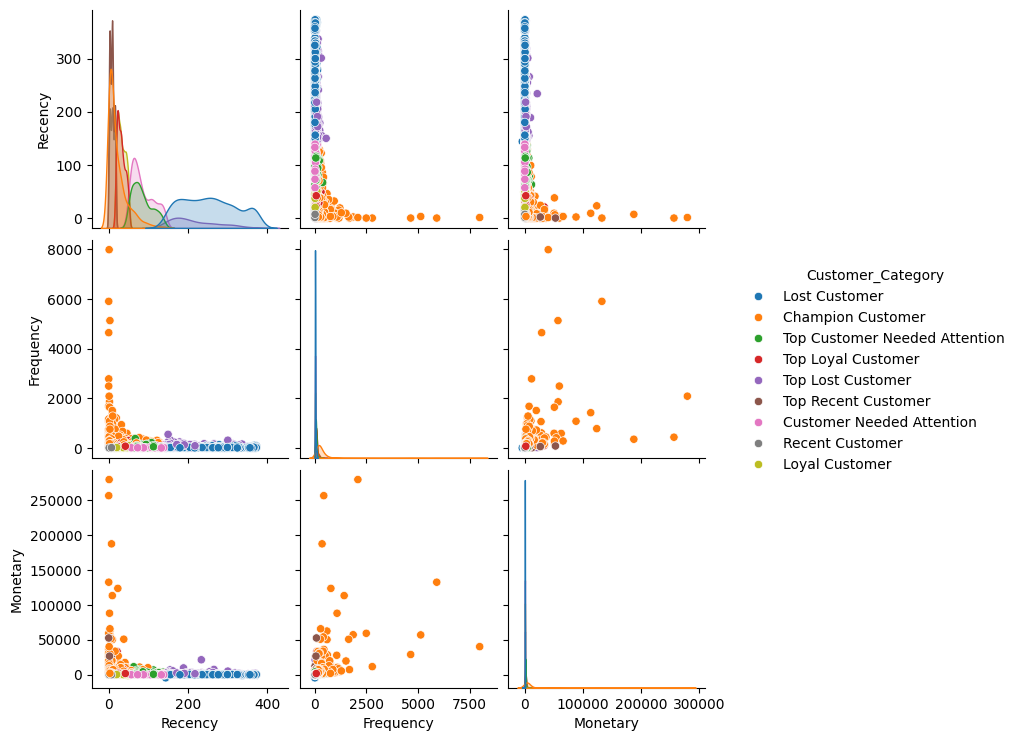

In [37]:
plt.figure(figsize=(20, 20))
sns.pairplot(rfm[['Recency', 'Frequency', 'Monetary','Customer_Category']], hue='Customer_Category');

In [38]:
fig = px.scatter_matrix(rfm,
                        dimensions=['Recency', 'Frequency', 'Monetary'],
                        color="Customer_Category",
                        width=1000, height=800)

fig.show()

# Data Normalization

In [39]:
fig = px.histogram(rfm, x=['Recency', 'Frequency', 'Monetary'], nbins=50)
fig.show()

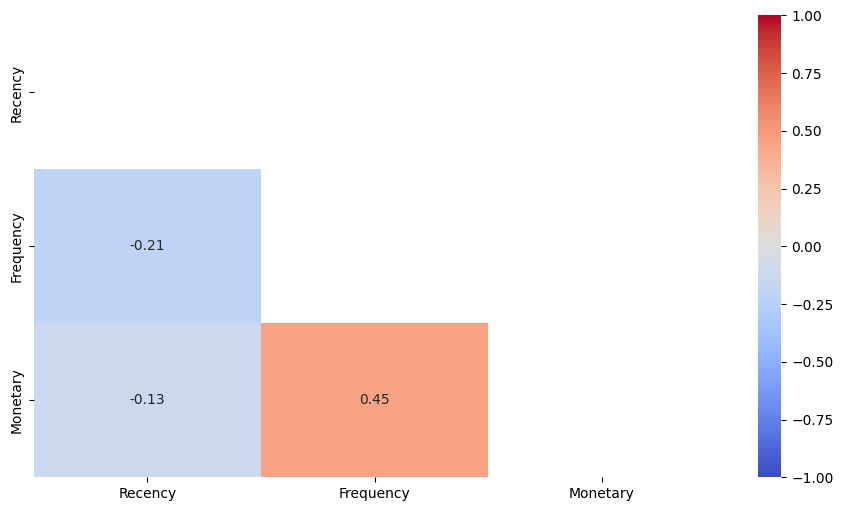

In [40]:
matrix = np.triu(rfm[['Recency','Frequency','Monetary']].corr())
fig, ax = plt.subplots(figsize=(11, 6))
sns.heatmap (rfm[['Recency','Frequency','Monetary']].corr(),
             annot=True,
             fmt= '.2f',
             vmin=-1,
             vmax=1,
             center=0,
             cmap='coolwarm',
             mask=matrix,
             ax=ax);

Text(0.5, 0, 'Attributes')

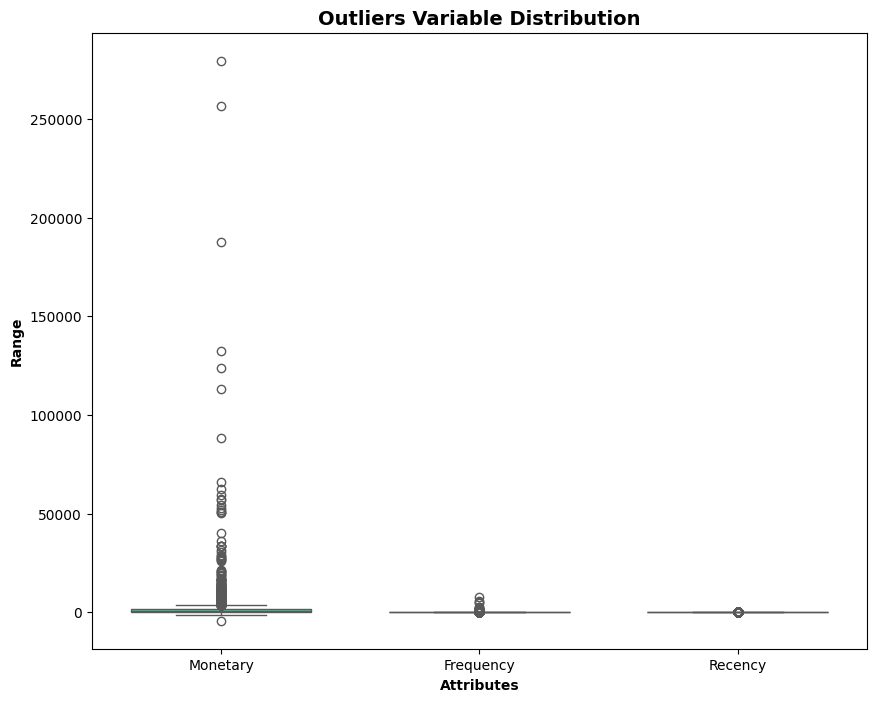

In [41]:
# Outlier Analysis of Monetary, Frequency and Recency

attributes = ['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [42]:
# Removing (statistical) outliers for Monetary
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [43]:
# Set threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
skew_limit = 0.75
skew_vals = rfm[['Recency', 'Frequency', 'Monetary']].skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols

Monetary     3.108102
Frequency    2.688333
Recency      1.229271
dtype: float64

In [44]:
rfm_log = rfm[skew_cols.index].copy()

for col in skew_cols.index.values:
    rfm_log[col] = rfm_log[col].apply(np.log1p)

    print(rfm_log.skew())
print()

rfm_log.head(10)

Monetary    -0.414944
Frequency    2.688333
Recency      1.229271
dtype: float64
Monetary    -0.414944
Frequency   -0.178630
Recency      1.229271
dtype: float64
Monetary    -0.414944
Frequency   -0.178630
Recency     -0.538190
dtype: float64



Monetary  Frequency   Recency
0  0.000000   1.098612  5.786897
1  8.368925   5.209486  0.693147
2  7.494564   3.465736  4.317488
3  7.472245   4.304065  2.944439
4  5.815324   2.890372  5.736572
5  7.343691   4.564348  3.583519
6  4.499810   1.609438  5.318120
7  6.985087   4.077537  5.446737
8  6.132096   2.639057  5.365976
9  7.941804   4.094345  3.135494

In [45]:
# Handling with Skewness - Power Transformer
from sklearn.preprocessing import PowerTransformer
rfm_before_powertrans = rfm[skew_cols.index].copy()
powertrans = PowerTransformer(method='yeo-johnson')
rfm_after_powertrans= powertrans.fit_transform(rfm_before_powertrans)
rfm_trans = pd.DataFrame(rfm_after_powertrans, columns =skew_cols.index )

print(rfm_trans.skew())
print()

Monetary     0.846015
Frequency   -0.009054
Recency     -0.072026
dtype: float64



<Figure size 2000x2000 with 0 Axes>

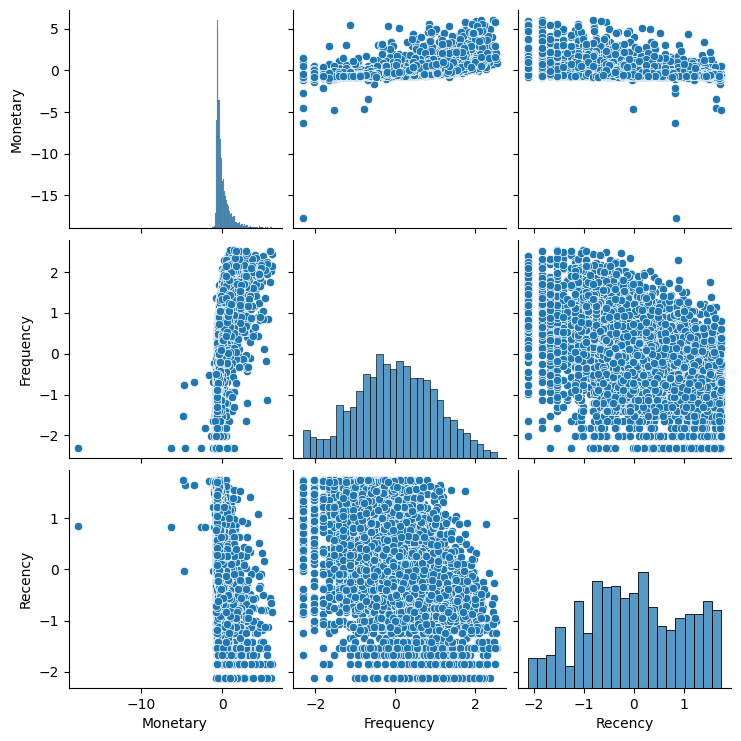

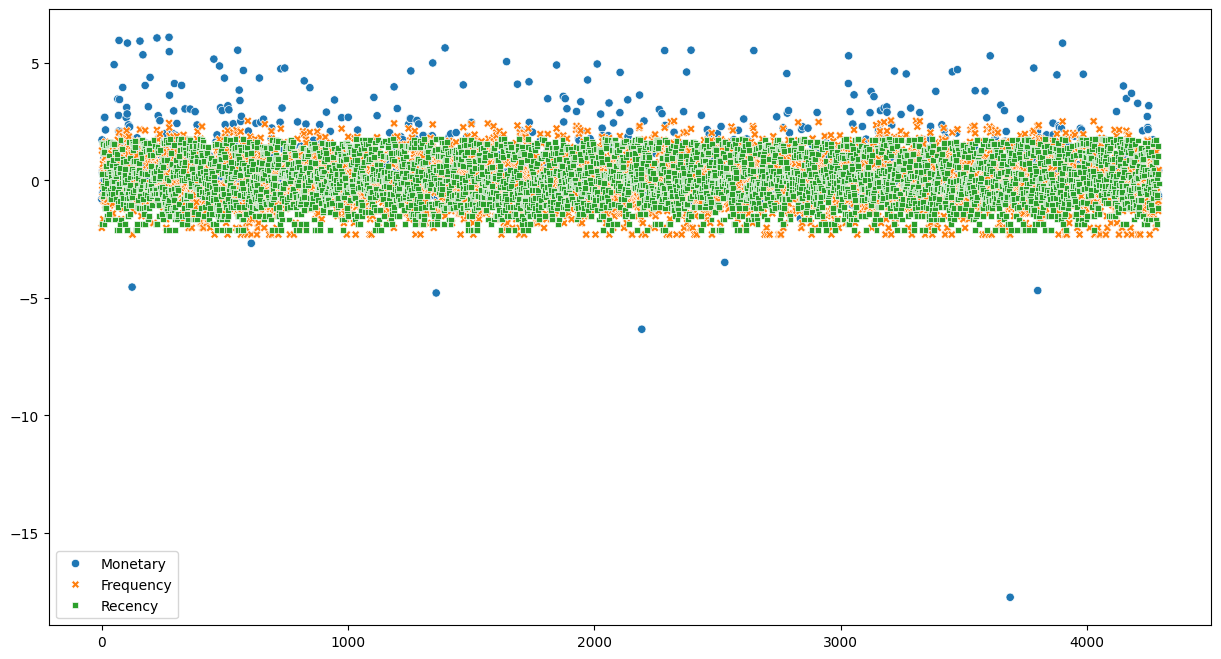

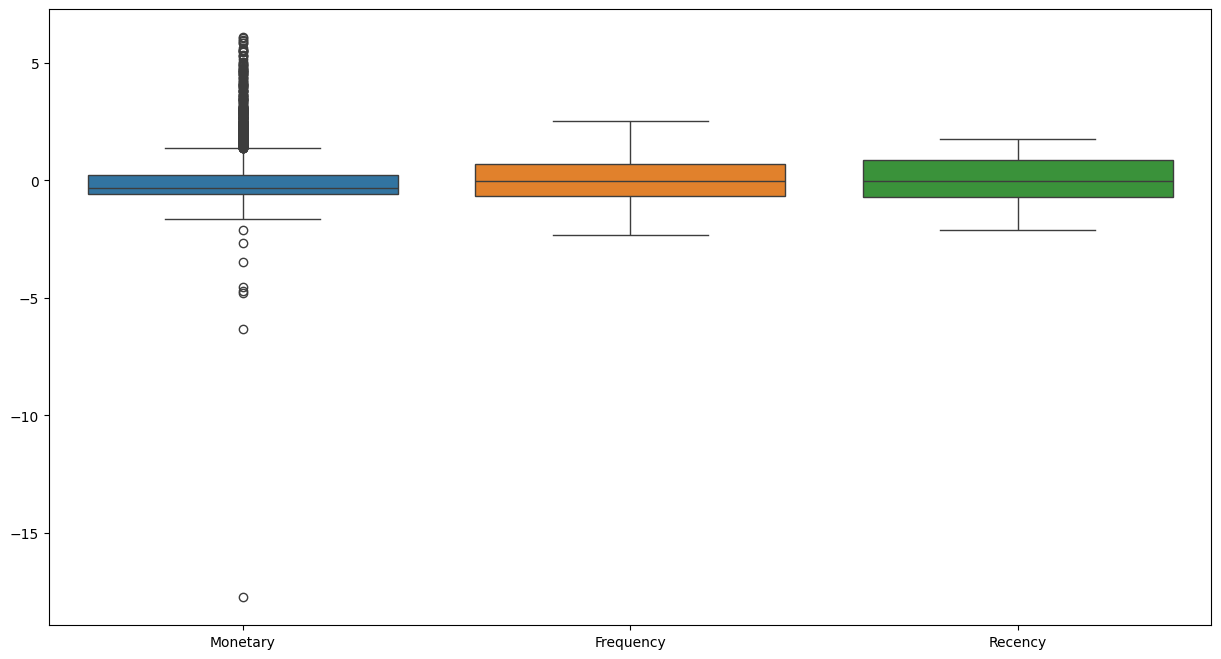

In [46]:
# Analyse with power tranformed data

plt.figure(figsize = (20,20));
sns.pairplot(rfm_trans);

plt.figure(figsize = (15, 8))
sns.scatterplot(data = rfm_trans);

plt.figure(figsize = (15, 8))
sns.boxplot(data = rfm_trans);

In [47]:
fig = px.scatter_3d(rfm_trans,
                    x='Recency',
                    y='Frequency',
                    z='Monetary',
                    color='Frequency')
fig.show();

# Scaling the features

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

rfm_df = rfm[['Monetary', 'Frequency', 'Recency']]

# Step 1: Standardization
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_trans)
rfm_df_scaled.shape



(4293, 3)

#  K-Means++ Clustering - Elbow Curve to get the right number of Clusters

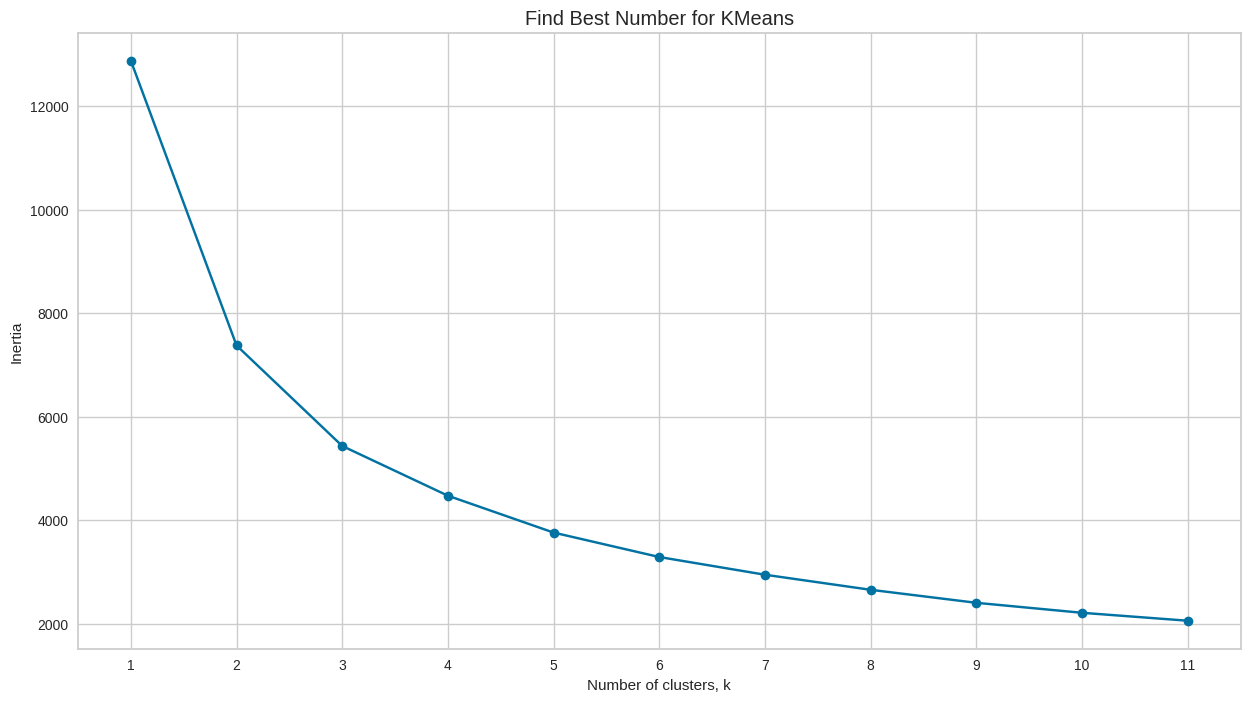

In [49]:
# Get the Best KMeans
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import scale
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_samples,silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from yellowbrick.cluster import KElbowVisualizer
kmeans = range(1, 12)
inertias=[]
for k in kmeans :
    # Create a KMeans++ clusters
    kc = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kc.fit(rfm_df_scaled)
    inertias.append(kc.inertia_)

# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(kmeans, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(kmeans)
plt.style.use('ggplot')
plt.title('Find Best Number for KMeans')
plt.show()

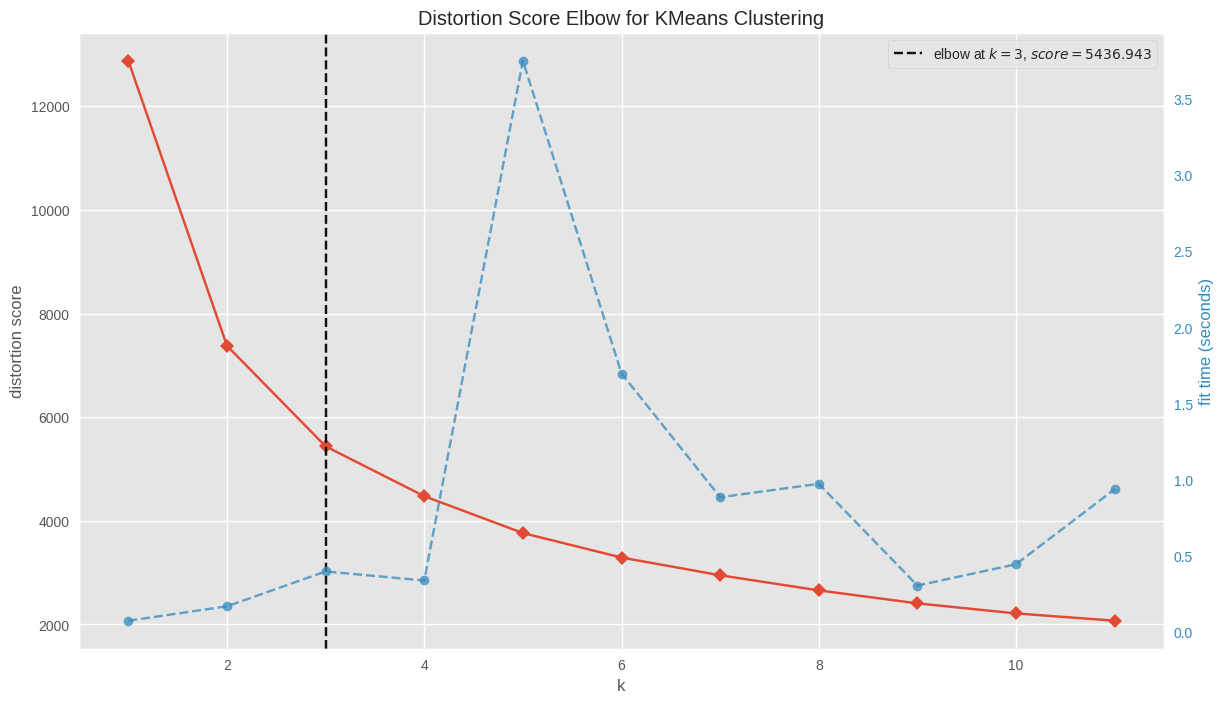

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [50]:
# Using rfm_df_scaled data from now

plt.rcParams['figure.facecolor'] = 'white'
model = KMeans(n_clusters=k,init='k-means++')
visualizer = KElbowVisualizer(model, k=(1, 12))

plt.figure(figsize=(14, 8))
# Fit the data to the visualizer
visualizer.fit(rfm_df_scaled)
visualizer.show()

In the above visualizer plot, the KElbowVisualizer fits the model for a range of RFM clusters values from 1 to 11, which is set by the parameter k=(1, 12).

When the model is fit with 3 clusters we can see an "elbow" in the graph, which in this case we know to be the optimal number since we created our synthetic dataset with 3 clusters of points.

According to the Elbow method, our recommendation is to apply 3 n_clusters for modeling.

Silhouette Score for 2 clusters: 0.3935596670349427
Silhouette Score for 3 clusters: 0.3514647942151345
Silhouette Score for 4 clusters: 0.3135219941676226
Silhouette Score for 5 clusters: 0.3100782339232265
Silhouette Score for 6 clusters: 0.30631133209377115
Silhouette Score for 7 clusters: 0.29514702574775725
Silhouette Score for 8 clusters: 0.2957135176525436
Silhouette Score for 9 clusters: 0.29280695371545334
Silhouette Score for 10 clusters: 0.29430442481761293
Silhouette Score for 11 clusters: 0.2867215188502441


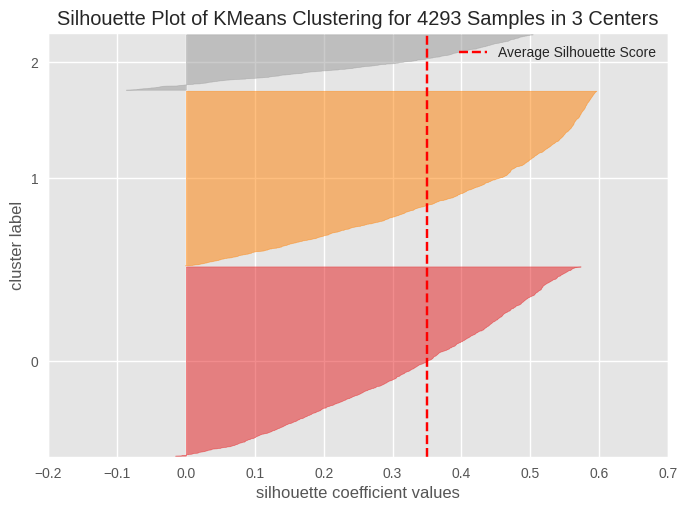

In [51]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
ssd =[]
K = range(2, 12)
for k in K:
    model = KMeans(n_clusters=k,init='k-means++')
    model.fit(rfm_df_scaled)
    ssd.append(model.inertia_)
    print(f'Silhouette Score for {k} clusters: {silhouette_score(rfm_df_scaled, model.labels_)}')

model_3 = KMeans(n_clusters=3, init='k-means++', random_state=42)
visualizer = SilhouetteVisualizer(model_3)
# Fit the data to the visualizer
visualizer.fit(rfm_df_scaled)
visualizer.poof();

In [52]:
# Perform Silhouette Analysis for a range of k values and visualize the results
import matplotlib.gridspec as gridspec

def silhouette_analysis(df, k_start, k_stop, figsize=(15, 16)):
    plt.figure(figsize=figsize)
    grid = gridspec.GridSpec(k_stop - k_start + 1, 2)
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(k_start, k_stop + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        kmeans.fit(df)
        labels = kmeans.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = k_start + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(k_start, k_stop + 1), silhouette_scores, marker='o')
    plt.xticks(range(k_start, k_stop + 1))
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Avg. Silhouette Score for Different k Values', fontsize=15)

    # Add optimal k value to the plot
    optimal_k_text = f'The k value with the highest Silhouette Score is: {best_k+1}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))


    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(k_start, k_stop + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - k_start, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(kmeans, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, kmeans.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

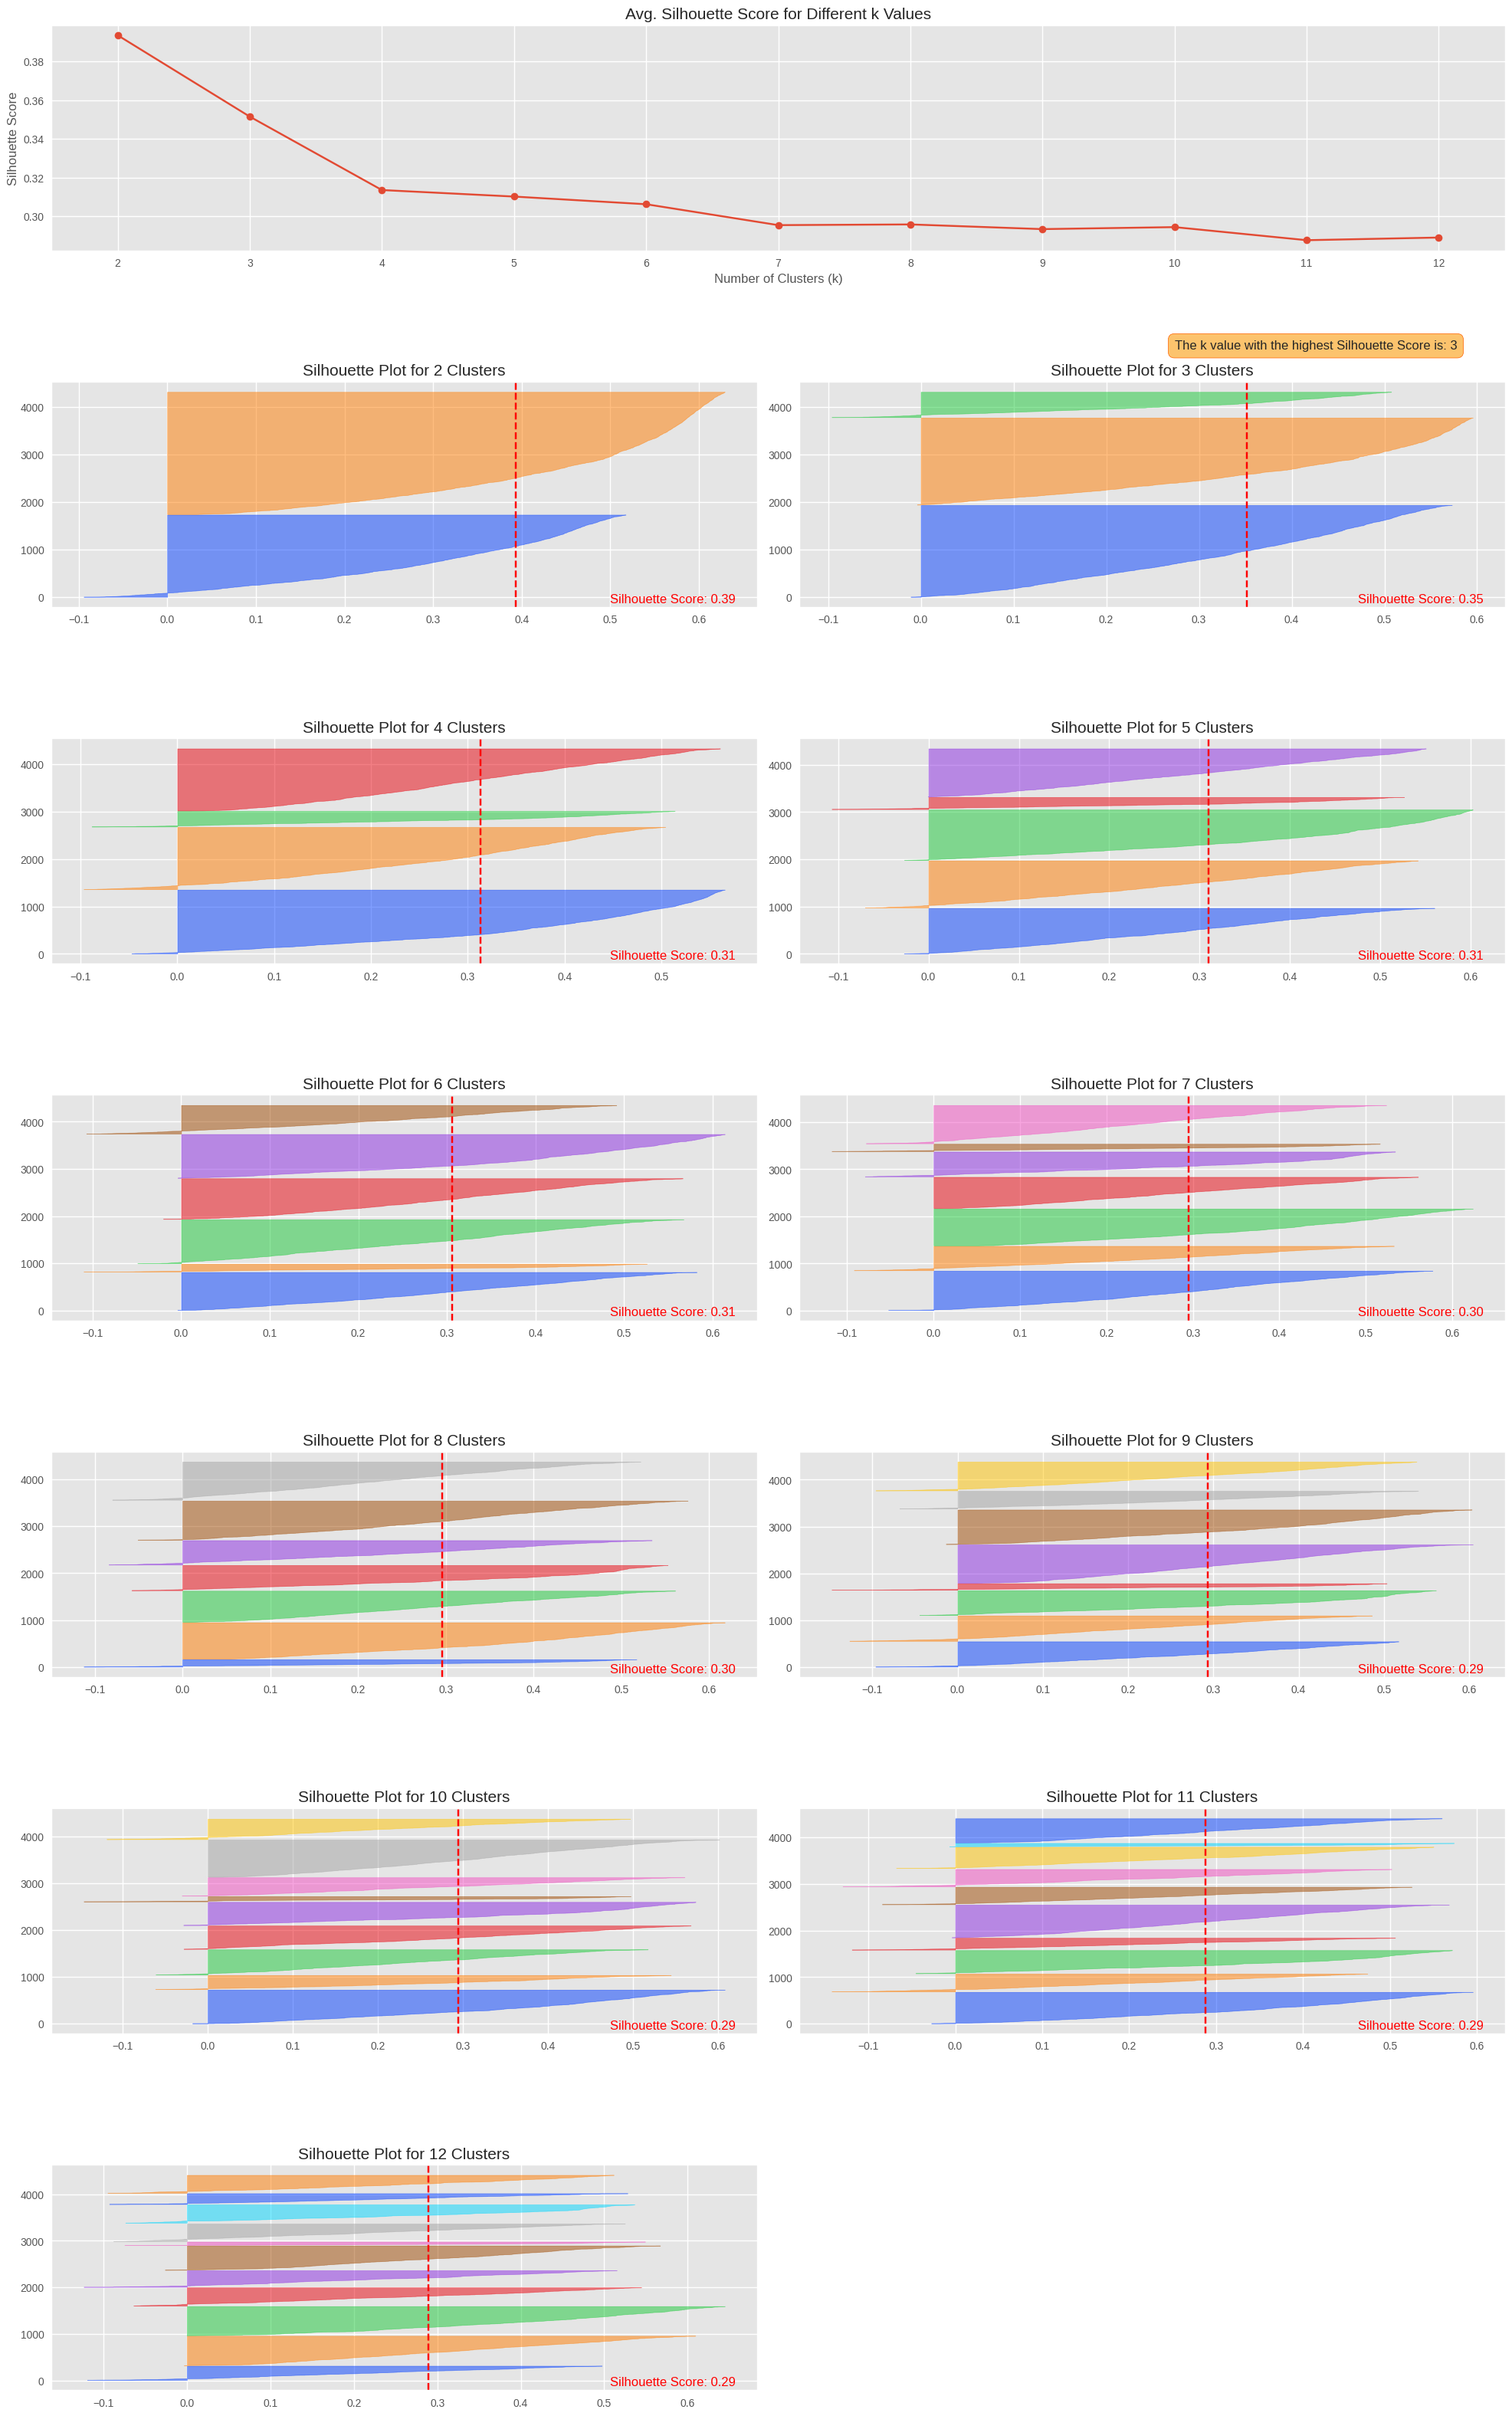

In [53]:
silhouette_analysis(rfm_df_scaled, 2, 12, figsize=(20, 50))

Silhouette Score computes the density of clusters and it is computed by averaging the silhouette coefficient value of each record, computed as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each record, normalized by the maximum value. This produces a score between 1 and -1, where 1 is highly dense clusters and -1 is completely incorrect clustering.

In the SilhouetteVisualizer plot above, clusters with higher scores have wider silhouettes, but clusters that are less cohesive will fall short of the average score across all clusters, which is plotted as a vertical dotted red line. In other words, the vertical red-dotted line on the plot indicates the average silhouette score for all observations.

# Kmeans++ Intercluster Distance Map

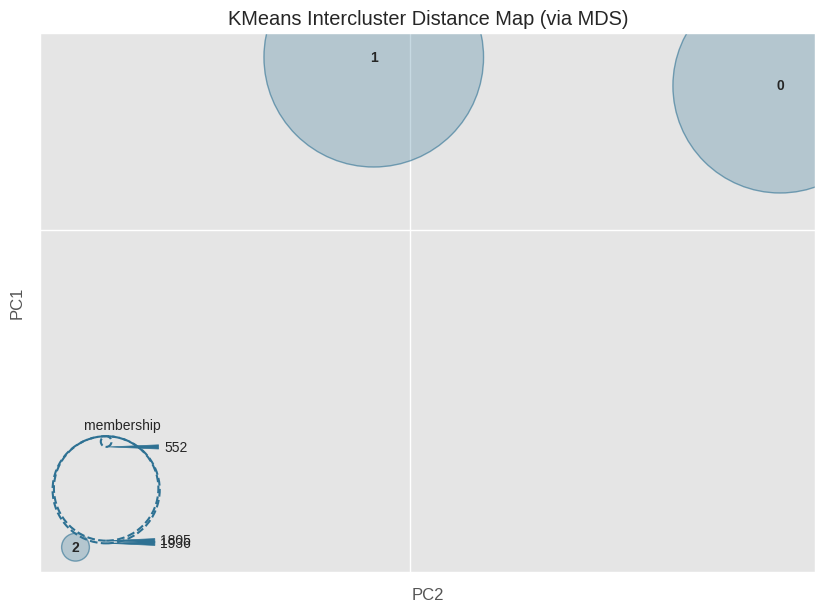

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [54]:
from yellowbrick.cluster import InterclusterDistance
plt.rcParams["figure.figsize"] = (10, 7)

# Instantiate the clustering model and visualizer
model = KMeans(3,init='k-means++')
visualizer = InterclusterDistance(model)

visualizer.fit(rfm_df_scaled)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

Intercluster distance map visualizations used to analyze the spatial relationships between clusters. These maps provide insights into how distinct clusters are distributed relative to each other in the feature space.

Here's how intercluster distance maps are typically constructed:

Clustering: First, the data is clustered using a clustering algorithm such as K-means++ clustering. Each data point is assigned to a specific cluster based on its similarity to other data points.

Intercluster Distances: For each pair of clusters, calculate the distance between them. This distance can be defined in various ways, such as the distance between cluster centroids, the distance between the closest pair of points from each cluster, or the average distance between points from one cluster to the points of another.

Visualization: The distances between clusters are then visualized using a map, where each cluster is represented as a point, and the distances between clusters are represented by lines or colored regions. The length or color intensity of the lines/regions corresponds to the distance between the clusters: shorter lines or darker regions indicate closer clusters, while longer lines or lighter regions indicate more distant clusters.

Intercluster distance maps help in understanding the relationships between clusters and identifying any patterns or structures in the data. They can also be useful for determining the optimal number of clusters and assessing the quality of the clustering solution. Additionally, intercluster distance maps can aid in identifying outliers or anomalies that may be located between clusters or far away from any cluster.

# Model Fitting

In [55]:
kmeans = KMeans(n_clusters = 3, init='k-means++').fit(rfm_df_scaled)
kmeans.predict(rfm_df_scaled)
labels = kmeans.labels_
rfm_trans['ClusterID']=labels
rfm_trans

Monetary  Frequency   Recency  ClusterID
0    -0.801179  -2.023144  1.608808          0
1     1.719326   1.266546 -1.842126          2
2     0.375559  -0.223704  0.285551          1
3     0.352890   0.474233 -0.680553          1
4    -0.529608  -0.683728  1.557694          0
...        ...        ...       ...        ...
4288 -0.647831  -1.138324  0.274950          0
4289 -0.642674  -1.065644  1.448551          0
4290 -0.722849  -1.306944  1.038174          0
4291 -0.645750  -0.879965 -1.181135          1
4292  0.398363   0.438989 -0.133754          1

[4293 rows x 4 columns]

In [56]:
rfm_trans.ClusterID.value_counts()

ClusterID
1    1927
0    1814
2     552
Name: count, dtype: int64

In [57]:
rfm['ClusterID'] = labels
rfm.sample(20)


CustomerID  Monetary  Frequency  Recency  Recency_Score  Frequency_Score  \
1762    14725.0    718.08         52       24              3                3   
4192    18044.0   2085.65        128        3              4                4   
3181    16655.0   3794.52        261       17              4                4   
1832    14823.0    321.43         70      179              1                3   
1740    14697.0    188.61         22      217              1                2   
4150    17979.0    737.81        147       35              3                4   
3637    17288.0   1419.73        142        8              4                4   
1707    14652.0    114.18         29       76              2                2   
2198    15318.0    312.62         33        3              4                2   
3338    16858.0    345.89         13      365              1                1   
3451    17019.0   1272.61        234       10              4                4   
3828    17547.0    -11.80          2      371              1                1   
1465    14327.0    311.65         12      162              1                1   
2080    15160.0    158.16          4      356              1                1   
864     13494.0    316.26         18      311              1                2   
1938    14974.0    114.39         21       36              3                2   
662     13216.0    333.74          5      267              1                1   
4127    17951.0    990.84         21       39              3                2   
5       12352.0   1545.41         95       35              3                3   
513     13008.0    178.47         15      322              1                1   

      Monetary_Score Customer_RFM_Score  RFM_Label          Customer_Category  \
1762               3                333          9         Top Loyal Customer   
4192               4                444         12          Champion Customer   
3181               4                444         12          Champion Customer   
1832               2                132          6              Lost Customer   
1740               1                121          4              Lost Customer   
4150               3                343         10         Top Loyal Customer   
3637               3                443         11        Top Recent Customer   
1707               1                221          5  Customer Needed Attention   
2198               2                422          8            Recent Customer   
3338               2                112          4              Lost Customer   
3451               3                443         11        Top Recent Customer   
3828               1                111          3              Lost Customer   
1465               2                112          4              Lost Customer   
2080               1                111          3              Lost Customer   
864                2                122          5              Lost Customer   
1938               1                321          6             Loyal Customer   
662                2                112          4              Lost Customer   
4127               3                323          8         Top Loyal Customer   
5                  3                333          9         Top Loyal Customer   
513                1                111          3              Lost Customer   

      ClusterID  
1762          1  
4192          1  
3181          2  
1832          0  
1740          0  
4150          1  
3637          1  
1707          0  
2198          1  
3338          0  
3451          1  
3828          0  
1465          0  
2080          0  
864           0  
1938          1  
662           0  
4127          1  
5             1  
513           0

In [58]:
rfm_trans.sample(8)

Monetary  Frequency   Recency  ClusterID
14   -0.635555  -1.065644  1.480255          0
3835 -0.653883  -1.218209 -0.617638          0
2756 -0.261866  -0.276061  0.908738          0
1497 -0.056498  -0.826373  1.560952          0
3923  0.642749   0.783816 -1.181135          1
2815 -0.190429   1.015159  1.583517          0
4100 -0.688640  -0.276061  0.583180          0
2937  0.152550   0.741821 -0.024036          1

# Cluster Visualization

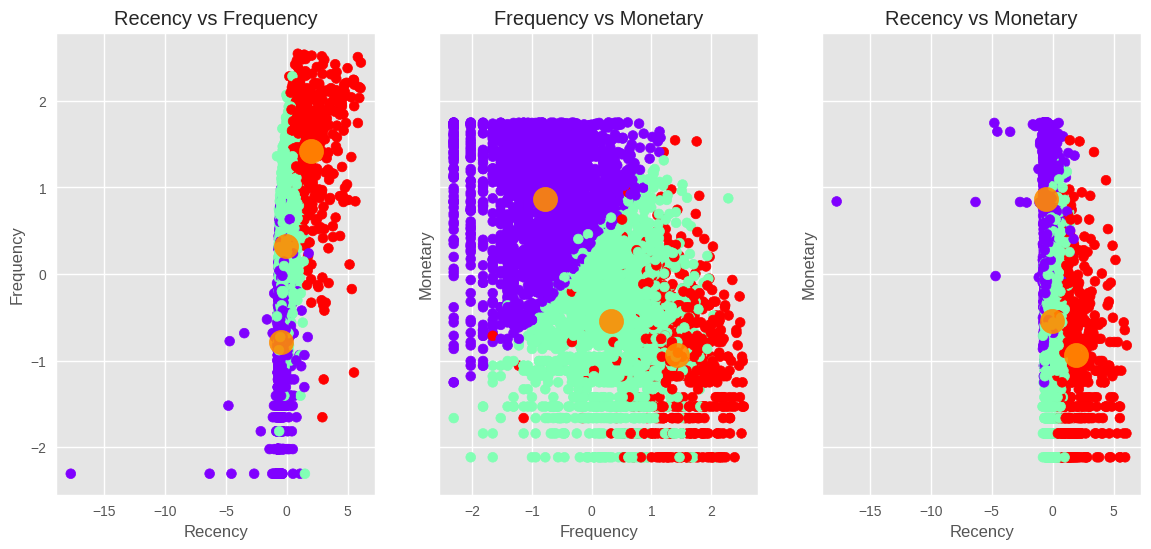

In [59]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(14, 6))

ax3.set_title("Recency vs Monetary")
ax3.set_xlabel('Recency')
ax3.set_ylabel('Monetary')
ax3.scatter(rfm_trans.iloc[:, 0], rfm_trans.iloc[:, 2], c=kmeans.labels_,cmap="rainbow")
ax3.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 2], s=300, alpha=0.9, label = 'Centroids');

ax2.set_title("Frequency vs Monetary")
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Monetary')
ax2.scatter(rfm_trans.iloc[:, 1], rfm_trans.iloc[:, 2], c=kmeans.labels_,cmap="rainbow")
ax2.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=300, alpha=0.9, label = 'Centroids')

ax1.set_title('Recency vs Frequency')
ax1.set_xlabel('Recency')
ax1.set_ylabel('Frequency')
ax1.scatter(rfm_trans.iloc[:, 0], rfm_trans.iloc[:, 1], c=kmeans.labels_, cmap="rainbow")
ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, alpha=0.9, label = 'Centroids')



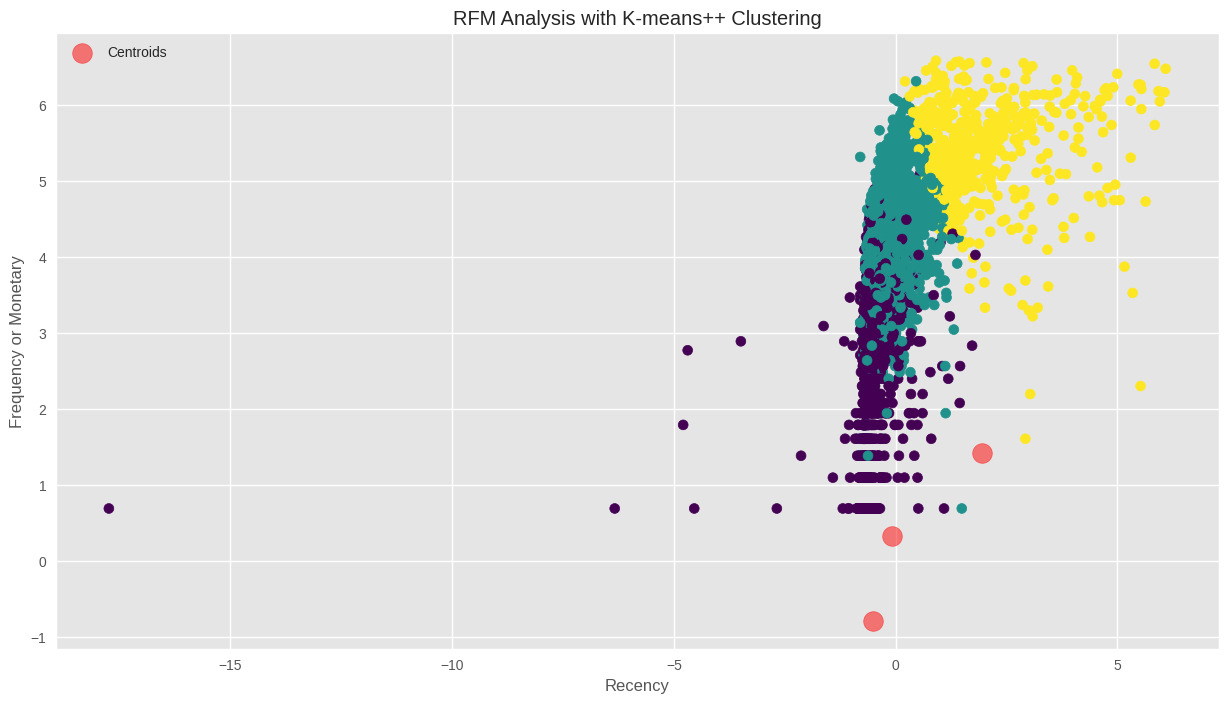

In [60]:
plt.figure(figsize=(15, 8))
plt.scatter(rfm_trans.iloc[:, 0], rfm_log.iloc[:, 1], c = labels, s = 50, cmap = "viridis")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red',alpha=0.5, label = 'Centroids');
plt.xlabel('Recency')
plt.ylabel('Frequency or Monetary')
plt.title('RFM Analysis with K-means++ Clustering')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
import plotly.graph_objs as go

# Define data traces for scatter plot and centroids
scatter_trace = go.Scatter3d(
    x=rfm_trans.iloc[:, 0],
    y=rfm_trans.iloc[:, 1],
    z=rfm_trans.iloc[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=kmeans.labels_,
        colorscale='Rainbow',
        opacity=0.8
    ),
    name='Data Points'
)

centroid_trace = go.Scatter3d(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    #z=kmeans.cluster_centers_[:, 2],
    mode='markers',
    marker=dict(
        size=10,
        color='black',
        opacity=0.8
    ),
    name='Centroids'
)

# Define layout
layout = go.Layout(
    title='Recency vs Frequency vs Monetary',
    scene=dict(
        xaxis=dict(title='Recency'),
        yaxis=dict(title='Frequency'),
        zaxis=dict(title='Monetary')
    )
)

# Create figure
fig = go.Figure(data=[scatter_trace, centroid_trace], layout=layout)

# Show plot
fig.show()



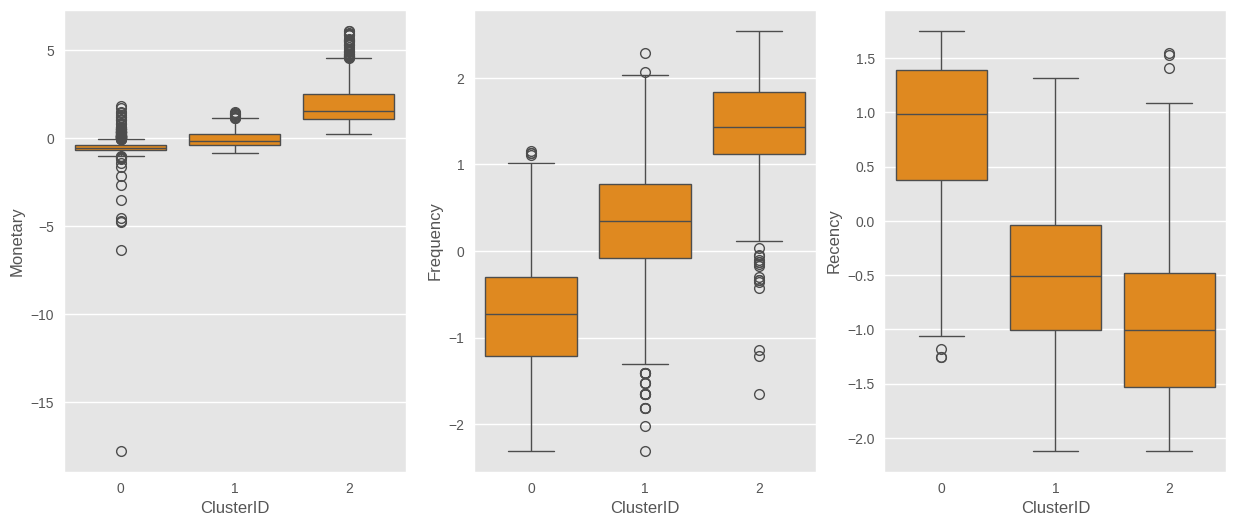

In [62]:
plt.figure(figsize=(15,6))

plt.subplot(1, 3, 1)
sns.boxplot(x='ClusterID', y='Monetary', data=rfm_trans)

plt.subplot(1, 3, 2)
sns.boxplot(x='ClusterID', y='Frequency', data=rfm_trans)

plt.subplot(1, 3, 3)
sns.boxplot(x='ClusterID', y='Recency', data=rfm_trans)
plt.show()

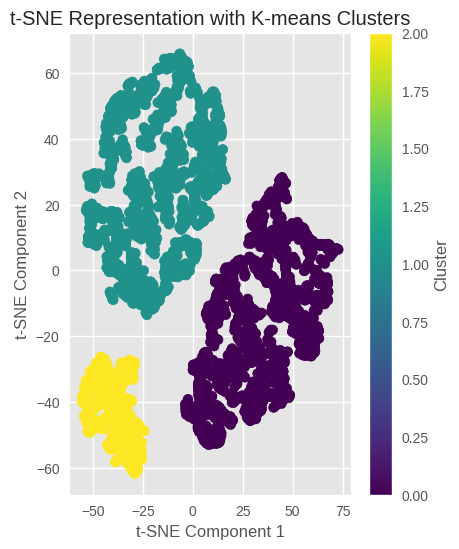

In [63]:
from sklearn.manifold import TSNE

# Step 1: t-SNE Dimensionality Reduction
tsne = TSNE(n_components=2, random_state=42)
rfm_tsne = tsne.fit_transform(rfm_trans)

# Step 2: Plotting
plt.figure(figsize=(10, 6))

# Plot t-SNE representation
plt.subplot(121)
plt.scatter(rfm_tsne[:, 0], rfm_tsne[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('t-SNE Representation with K-means Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')

In [64]:
rfm_trans['Labels'] = rfm_trans['ClusterID'].map({0:'Lost/Needed Attention Customers', 1:'Current Customer', 2:'Top/Best Customer'})
rfm_trans.sample(10)

Monetary  Frequency   Recency  ClusterID  \
4167 -0.539335   0.485683 -0.479672          1   
3355 -0.540547  -0.524999  1.078165          0   
1773 -0.629666  -1.406825 -0.407133          0   
915  -0.691991  -1.065644  1.554427          0   
3909 -0.707740  -1.218209  1.284210          0   
3516 -0.523780  -0.020841  0.033065          1   
737  -0.009141   0.207989  0.458849          1   
1591  1.599419   2.301889 -1.664947          2   
1849  0.125613   0.238475 -1.181135          1   
752  -0.501773  -0.728608  0.185587          0   

                               Labels  
4167                 Current Customer  
3355  Lost/Needed Attention Customers  
1773  Lost/Needed Attention Customers  
915   Lost/Needed Attention Customers  
3909  Lost/Needed Attention Customers  
3516                 Current Customer  
737                  Current Customer  
1591                Top/Best Customer  
1849                 Current Customer  
752   Lost/Needed Attention Customers

In [65]:
rfm_trans[rfm_trans['Labels'] == "Lost/Needed Attention Customers"]

Monetary  Frequency   Recency  ClusterID  \
0    -0.801179  -2.023144  1.608808          0   
4    -0.529608  -0.683728  1.557694          0   
6    -0.715927  -1.655151  1.149519          0   
7    -0.046495   0.282333  1.271840          0   
8    -0.442855  -0.879965  1.194714          0   
...        ...        ...       ...        ...   
4282 -0.598704  -0.879965 -0.221564          0   
4287 -0.708711  -1.138324  0.086771          0   
4288 -0.647831  -1.138324  0.274950          0   
4289 -0.642674  -1.065644  1.448551          0   
4290 -0.722849  -1.306944  1.038174          0   

                               Labels  
0     Lost/Needed Attention Customers  
4     Lost/Needed Attention Customers  
6     Lost/Needed Attention Customers  
7     Lost/Needed Attention Customers  
8     Lost/Needed Attention Customers  
...                               ...  
4282  Lost/Needed Attention Customers  
4287  Lost/Needed Attention Customers  
4288  Lost/Needed Attention Customers  
4289  Lost/Needed Attention Customers  
4290  Lost/Needed Attention Customers  

[1814 rows x 5 columns]

In [66]:
rfm_trans[rfm_trans['Labels'] == "Top/Best Customer"]

Monetary  Frequency   Recency  ClusterID             Labels
1     1.719326   1.266546 -1.842126          2  Top/Best Customer
10    2.661698   0.975934 -0.319506          2  Top/Best Customer
12    2.680076   1.567293 -1.181135          2  Top/Best Customer
15    2.144259   1.636539 -1.664947          2  Top/Best Customer
20    1.325358   1.189942 -0.009417          2  Top/Best Customer
...        ...        ...       ...        ...                ...
4248  2.246698   1.675841 -1.664947          2  Top/Best Customer
4249  2.162916   1.534446 -0.203268          2  Top/Best Customer
4252  3.175496   1.173850 -0.955817          2  Top/Best Customer
4264  0.771577   1.241691 -1.251938          2  Top/Best Customer
4283  1.071885   1.205765 -1.664947          2  Top/Best Customer

[552 rows x 5 columns]

In [67]:
rfm_trans[rfm_trans['Labels'] == "Current Customer"]

Monetary  Frequency   Recency  ClusterID            Labels
2     0.375559  -0.223704  0.285551          1  Current Customer
3     0.352890   0.474233 -0.680553          1  Current Customer
5     0.230555   0.697818 -0.259383          1  Current Customer
9     0.936308   0.296486 -0.559495          1  Current Customer
11    0.007246  -0.600616 -1.842126          1  Current Customer
...        ...        ...       ...        ...               ...
4284 -0.624848  -1.817223 -1.842126          1  Current Customer
4285 -0.801179  -0.489591 -0.714089          1  Current Customer
4286 -0.537453  -0.728608 -0.617638          1  Current Customer
4291 -0.645750  -0.879965 -1.181135          1  Current Customer
4292  0.398363   0.438989 -0.133754          1  Current Customer

[1927 rows x 5 columns]

In [68]:
rfm[rfm['ClusterID'] == 0].sample(10)

CustomerID  Monetary  Frequency  Recency  Recency_Score  Frequency_Score  \
1729    14681.0    498.95          7       70              2                1   
3715    17394.0    203.87          4      218              1                1   
547     13059.0    183.40          8      249              1                1   
466     12942.0    683.90         75      130              2                3   
1461    14320.0    343.11         42      206              1                2   
799     13402.0    621.23         39      126              2                2   
1734    14689.0    112.80         13      208              1                1   
882     13514.0    152.20          4       73              2                1   
4359    18269.0    138.90          8      357              1                1   
3068    16494.0    826.53         50      296              1                3   

      Monetary_Score Customer_RFM_Score  RFM_Label  \
1729               2                212          5   
3715               1                111          3   
547                1                111          3   
466                3                233          8   
1461               2                122          5   
799                2                222          6   
1734               1                111          3   
882                1                211          4   
4359               1                111          3   
3068               3                133          7   

                  Customer_Category  ClusterID  
1729      Customer Needed Attention          0  
3715                  Lost Customer          0  
547                   Lost Customer          0  
466   Top Customer Needed Attention          0  
1461                  Lost Customer          0  
799       Customer Needed Attention          0  
1734                  Lost Customer          0  
882       Customer Needed Attention          0  
4359                  Lost Customer          0  
3068              Top Lost Customer          0

In [69]:
rfm[rfm['ClusterID'] == 1].sample(10)

CustomerID  Monetary  Frequency  Recency  Recency_Score  Frequency_Score  \
4258    18136.0    761.83         39       62              2                2   
2841    16185.0    529.41         31       16              4                2   
1525    14412.0    761.33         45       34              3                3   
2673    15965.0    845.64        122       16              4                4   
1253    14034.0    512.02         92       21              3                3   
3234    16726.0   1382.02        185       25              3                4   
3893    17636.0    265.93         24        8              4                2   
2200    15320.0    267.13         36       43              3                2   
1639    14553.0    859.27        113       18              3                4   
1179    13931.0   1230.93         59       85              2                3   

      Monetary_Score Customer_RFM_Score  RFM_Label  \
4258               3                223          7   
2841               2                422          8   
1525               3                333          9   
2673               3                443         11   
1253               2                332          8   
3234               3                343         10   
3893               1                421          7   
2200               1                321          6   
1639               3                343         10   
1179               3                233          8   

                  Customer_Category  ClusterID  
4258  Top Customer Needed Attention          1  
2841                Recent Customer          1  
1525             Top Loyal Customer          1  
2673            Top Recent Customer          1  
1253                 Loyal Customer          1  
3234             Top Loyal Customer          1  
3893                Recent Customer          1  
2200                 Loyal Customer          1  
1639             Top Loyal Customer          1  
1179  Top Customer Needed Attention          1

In [70]:
rfm[rfm['ClusterID'] == 2].sample(10)

CustomerID  Monetary  Frequency  Recency  Recency_Score  Frequency_Score  \
516     13013.0   4786.99        222        0              4                4   
4305    18198.0   5083.06        166        3              4                4   
2366    15544.0   3542.51        261        8              4                4   
487     12971.0  10930.26        308        3              4                4   
2992    16393.0   2941.05        358        1              4                4   
2894    16255.0   2609.30        274       16              4                4   
740     13319.0  10664.34        500        4              4                4   
112     12484.0   4495.27        350       32              3                4   
579     13102.0   6336.29        310        0              4                4   
3844    17567.0   4012.56        177        6              4                4   

      Monetary_Score Customer_RFM_Score  RFM_Label  Customer_Category  \
516                4                444         12  Champion Customer   
4305               4                444         12  Champion Customer   
2366               4                444         12  Champion Customer   
487                4                444         12  Champion Customer   
2992               4                444         12  Champion Customer   
2894               4                444         12  Champion Customer   
740                4                444         12  Champion Customer   
112                4                344         11  Champion Customer   
579                4                444         12  Champion Customer   
3844               4                444         12  Champion Customer   

      ClusterID  
516           2  
4305          2  
2366          2  
487           2  
2992          2  
2894          2  
740           2  
112           2  
579           2  
3844          2

In [71]:
rfm_trans.shape


(4293, 5)

In [72]:
rfm.shape

(4293, 11)

In [73]:
# Exctract Labels column from data frame
extracted_column = rfm_trans['Labels']

# Second dataframe after adding column from first dataframe
rfm.insert(10, "K-Means++ Predicted Category", extracted_column)
rfm['K-Means++ Predicted Category'] = rfm_trans['Labels'].values
rfm.sample(8)

CustomerID  Monetary  Frequency  Recency  Recency_Score  Frequency_Score  \
2121    15219.0    305.75          9      175              1                1   
2716    16022.0    628.28         76      259              1                3   
3944    17700.0   2508.89        146       16              4                4   
963     13634.0   1575.16        188       32              3                4   
3682    17353.0   1740.00          8      128              2                1   
942     13599.0   5030.60        264        0              4                4   
481     12963.0   1841.03         96        7              4                3   
2721    16027.0    852.12         17       91              2                1   

      Monetary_Score Customer_RFM_Score  RFM_Label  \
2121               2                112          4   
2716               2                132          6   
3944               4                444         12   
963                3                343         10   
3682               4                214          7   
942                4                444         12   
481                4                434         11   
2721               3                213          6   

                  Customer_Category     K-Means++ Predicted Category  \
2121                  Lost Customer  Lost/Needed Attention Customers   
2716                  Lost Customer  Lost/Needed Attention Customers   
3944              Champion Customer                 Current Customer   
963              Top Loyal Customer                 Current Customer   
3682  Top Customer Needed Attention  Lost/Needed Attention Customers   
942               Champion Customer                Top/Best Customer   
481             Top Recent Customer                 Current Customer   
2721  Top Customer Needed Attention  Lost/Needed Attention Customers   

      ClusterID  
2121          0  
2716          0  
3944          1  
963           1  
3682          0  
942           2  
481           1  
2721          0

In [74]:
rfm['Customer_Category'].value_counts()

Customer_Category
Lost Customer                    895
Champion Customer                707
Customer Needed Attention        558
Loyal Customer                   445
Top Recent Customer              420
Top Loyal Customer               398
Top Customer Needed Attention    396
Recent Customer                  288
Top Lost Customer                186
Name: count, dtype: int64

In [75]:
RFM_Customer_Segment = pd.DataFrame(rfm['Customer_Category'].value_counts(dropna=False).sort_values(ascending=False))
RFM_Customer_Segment.reset_index(inplace=True)
RFM_Customer_Segment.rename(columns={'index':'RFM Customer Segment', 'Customer_Category':'The Number Of Customer'}, inplace=True)
RFM_Customer_Segment


The Number Of Customer  count
0                  Lost Customer    895
1              Champion Customer    707
2      Customer Needed Attention    558
3                 Loyal Customer    445
4            Top Recent Customer    420
5             Top Loyal Customer    398
6  Top Customer Needed Attention    396
7                Recent Customer    288
8              Top Lost Customer    186

In [76]:
rfm['K-Means++ Predicted Category'].value_counts()

K-Means++ Predicted Category
Current Customer                   1927
Lost/Needed Attention Customers    1814
Top/Best Customer                   552
Name: count, dtype: int64

In [77]:
KMeans_Predicted_Clusters = pd.DataFrame(rfm['K-Means++ Predicted Category'].value_counts(dropna=False).sort_values(ascending=False))
KMeans_Predicted_Clusters.reset_index(inplace=True)
KMeans_Predicted_Clusters.rename(columns={'index':'K-Means++ Predicted Category', 'K-Means++ Predicted Category':'Number Of Customer'}, inplace=True)
KMeans_Predicted_Clusters

Number Of Customer  count
0                 Current Customer   1927
1  Lost/Needed Attention Customers   1814
2                Top/Best Customer    552

In [78]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(
    x=rfm['K-Means++ Predicted Category'].values,
    y=rfm['K-Means++ Predicted Category'].index,
    name='Predicted-Clusters By K-Means',
    marker_color='red'
))
fig.add_trace(go.Bar(
    x=rfm['Customer_Category'].values,
    y=rfm['Customer_Category'].index,
    name='Customer-Segment By RFM Analysis',
    marker_color='lightgreen'
))

fig.update_layout(barmode='relative',
                  xaxis_tickangle=-45,
                  title="Comparison of Predicted-Clusters By K-Means vs Customer-Segment By RFM Analysis")
fig.update_traces(dict(marker_line_width=0))
fig.show()

# Conclusion

The project utilizing RFM (Recency, Frequency, Monetary) analysis and K-means clustering has provided valuable insights into customer segmentation and behavior. Through this project, we aimed to understand and segment customers based on their purchasing patterns and identify meaningful clusters for targeted marketing strategies.

After conducting RFM analysis, we assessed customers' recency of purchase, frequency of purchase, and monetary value of transactions. This helped us categorize customers into distinct segments based on their engagement with the business.

Following RFM analysis, we applied K-means clustering to further segment customers into homogeneous groups. K-means clustering allowed us to identify patterns within the data and group customers based on similarities in their RFM characteristics.

**ClusterID # 0:**
This group falls under the "Lost Customer" or "Customer in Need of Attention" category. While they have previously visited and made purchases at varying frequencies, they have not been frequenting the store recently. We suggest the marketing team employ personalized promotions tailored to re-engage them.

**ClusterID # 1:**
These customers are classified as "Current Customers" who shop at different frequencies and spend varying amounts. We advise offering them membership or loyalty programs, as well as suggesting related products to upsell, with the aim of fostering loyalty. Additionally, renewal incentives and targeted product recommendations can encourage repeat purchases.

**ClusterID # 2:**
This segment consists of "Top/Best Customers" who have demonstrated average or recent shopping frequency coupled with substantial spending. We recommend rewarding them or offering membership and loyalty programs to cultivate them into champion customers.

Through this combined approach, we have successfully identified several clusters of customers, each exhibiting unique buying behaviors and preferences. These clusters enable us to tailor marketing strategies and promotional campaigns to better meet the needs and preferences of different customer segments.

Overall, this project highlights the significance of utilizing data-driven techniques such as RFM analysis and K-means clustering for customer segmentation and targeted marketing. By understanding customer behavior and preferences, businesses can optimize their marketing efforts, enhance customer satisfaction, and drive revenue growth.